# Time Series Forecasting in Python (2026): Predicting Apple Stock Prices

This notebook teaches **10 different ways to predict future stock prices** across:
1. Classic statistical methods (the old-school approaches)
2. Machine learning methods (the smart spreadsheet approaches)
3. Deep learning methods (the brain-inspired approaches)
4. Modern foundation models (the ChatGPT-style approaches)

For **each method**, you get:
- **Example:** A simple demo showing exactly how it works
- **Project:** A more complete version where we train and test the model

## What we're doing in this notebook
- **Data:** We download Apple (AAPL) stock prices from the internet
- **Goal:** Predict future prices using only past information (no time travel!)
- **Testing:** We always test on data the model has NEVER seen before
- **Speed:** Everything runs on a regular laptop in under 10 minutes

## Important rules we follow
- **No cheating:** We never use tomorrow's price to predict today
- **Time order matters:** We keep everything in chronological order (oldest to newest)
- **Fair testing:** We pick the best model settings using validation data, then test ONCE on completely new data
- **Reality check:** We always compare to simple baselines to make sure we're actually learning something useful

## About stock prices
Stock prices are REALLY hard to predict! Even if our models show good results here, that doesn't mean you should use them to actually trade stocks. Real trading is way more complicated and involves risks, fees, and many other factors we're not covering.

2

In [1]:
import warnings
warnings.filterwarnings('ignore')
# Suppress specific statsmodels convergence warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Ensure plots display inline in Jupyter notebooks
%matplotlib inline

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100


def report_metrics(name, y_true, y_pred):
    print(f"{name}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"  RMSE: {rmse(y_true, y_pred):.4f}")
    print(f"  MAPE: {mape(y_true, y_pred):.2f}%")

In [2]:
# URL-only data load (Stooq public CSV endpoint)
url = "https://stooq.com/q/d/l/?s=aapl.us&i=d"
df = pd.read_csv(url, parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Keep a practical time window for fast CPU training
df = df[df['Date'] >= '2015-01-01'].copy().reset_index(drop=True)

# Basic cleaning / target setup
for c in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.dropna().reset_index(drop=True)
df['y'] = df['Close']

df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].head(), df.tail(3)

(        Date     Open     High      Low    Close     Volume
 0 2015-01-02  24.6921  24.7037  23.8002  24.2374  239959065
 1 2015-01-05  24.0036  24.0802  23.3700  23.5555  289848502
 2 2015-01-06  23.6461  23.8160  23.1942  23.5575  296598610
 3 2015-01-07  23.7688  23.9820  23.6510  23.8917  180725843
 4 2015-01-08  24.2155  24.8669  24.0929  24.8079  267640572,
            Date     Open    High     Low   Close    Volume       y
 2793 2026-02-11  274.695  280.18  274.45  275.50  51931283  275.50
 2794 2026-02-12  275.590  275.72  260.18  261.73  81077229  261.73
 2795 2026-02-13  262.010  262.23  255.45  255.78  56290673  255.78)

In [3]:
df.shape

(2796, 7)

Rows: 2796
Train: 2015-01-02 to 2022-10-10 1957
Val  : 2022-10-11 to 2024-06-11 419
Test : 2024-06-12 to 2026-02-13 420


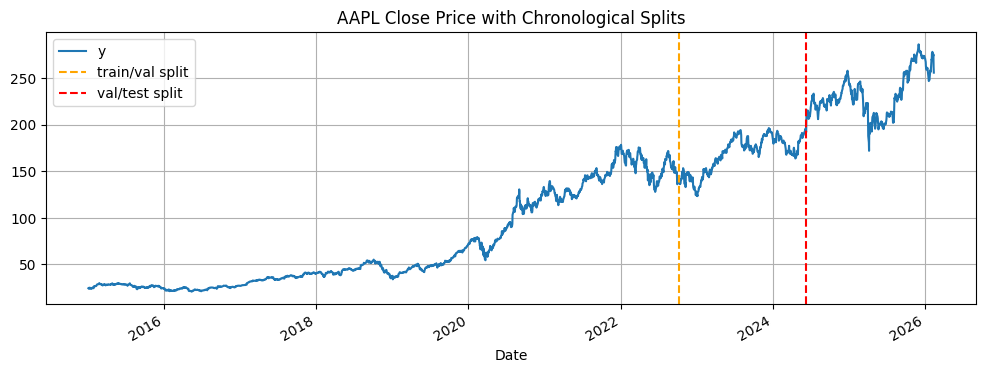

In [4]:
# Chronological split: train -> validation -> test
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

print('Rows:', n)
print('Train:', train_df['Date'].min().date(), 'to', train_df['Date'].max().date(), len(train_df))
print('Val  :', val_df['Date'].min().date(), 'to', val_df['Date'].max().date(), len(val_df))
print('Test :', test_df['Date'].min().date(), 'to', test_df['Date'].max().date(), len(test_df))

ax = df.plot(x='Date', y='y', title='AAPL Close Price with Chronological Splits')
ax.axvline(train_df['Date'].max(), color='orange', linestyle='--', label='train/val split')
ax.axvline(val_df['Date'].max(), color='red', linestyle='--', label='val/test split')
ax.legend()
plt.show()

In [5]:
def make_lag_features(frame, target_col='y', lags=(1,2,3,5,10,20), windows=(5,10,20)):
    out = frame[['Date', target_col, 'Volume']].copy()
    for lag in lags:
        out[f'lag_{lag}'] = out[target_col].shift(lag)
    for w in windows:
        out[f'roll_mean_{w}'] = out[target_col].shift(1).rolling(w).mean()
        out[f'roll_std_{w}'] = out[target_col].shift(1).rolling(w).std()
    out['dow'] = out['Date'].dt.dayofweek
    out['month'] = out['Date'].dt.month
    out = out.dropna().reset_index(drop=True)
    return out

lag_df = make_lag_features(df)
lag_df.head()

,Date,y,Volume,lag_1,lag_2,lag_3,lag_5,lag_10,lag_20,roll_mean_5,roll_std_5,roll_mean_10,roll_std_10,roll_mean_20,roll_std_20,dow,month
0,2015-02-02,26.2968,282595615,25.9767,26.3637,25.5641,25.0722,23.4937,24.2374,25.43396,0.843582,24.90181,0.899818,24.529425,0.797610,0,2
1,2015-02-03,26.3018,234099885,26.2968,25.9767,26.3637,24.1931,24.0979,23.5555,25.67888,0.888850,25.18212,0.847515,24.632395,0.885965,1,2
2,2015-02-04,26.5003,316111926,26.3018,26.2968,25.9767,25.5641,24.2904,23.5575,26.10062,0.335924,25.40251,0.820364,24.769710,0.922349,2,2
3,2015-02-05,26.6945,189753061,26.5003,26.3018,26.2968,26.3637,24.9179,23.8917,26.28786,0.192339,25.62350,0.784358,24.916850,0.953010,3,2
4,2015-02-06,26.4628,196270421,26.6945,26.5003,26.3018,25.9767,25.0484,24.8079,26.35402,0.267253,25.80116,0.807637,25.056990,0.999280,4,2


## 1) Classical Statistical Methods

These are the "oldschool" methods that statisticians have used for decades. They're really good when you don't have tons of data.

### Method 1: ARIMA
**What it does:** Imagine trying to predict tomorrow's temperature by looking at today's temp, yesterday's temp, and how much things usually change day-to-day. ARIMA does exactly that with three ingredients:
- It looks at recent values (that's the AR part)
- It removes trends to make the data "flat" so patterns are easier to see (that's the I part)
- It learns from past prediction mistakes (that's the MA part)

**When it works:** Great for data that has some consistent patterns but isn't too crazy or jumpy.
**When it fails:** Doesn't like sudden surprises or weird changes in behavior.

### Method 2: SARIMA
**What it does:** This is ARIMA's cooler sibling that also understands "seasons" or repeating patterns. Think about how ice cream sales might spike every summer, or how stocks might behave similarly every Monday. SARIMA catches those weekly, monthly, or yearly rhythms.

**When it works:** Perfect when your data has repeating cycles (like weekly patterns in stock trading).
**When it fails:** If the patterns keep changing or aren't consistent, it gets confused.

### Method 3: Exponential Smoothing (ETS)
**What it does:** This method is like having a smart average that pays more attention to recent stuff and gradually "forgets" old information. It tracks three things: the current level, whether things are going up or down (trend), and any repeating patterns (seasonality).

**When it works:** Excellent for smooth, steady data with clear trends.
**When it fails:** Doesn't handle sudden jumps or random spikes well.

### How we test these methods
1. Train the model on old data
2. Try different settings and pick the best one using validation data
3. Re-train with more data
4. Test once on brand new data to see how good it really is

Best ARIMA order selected: (3, 1, 2)
ARIMA Validation (walk-forward, order=(3, 1, 2))
  MAE : 3.3222
  RMSE: 4.2976
  MAPE: 2.02%
ARIMA Test (walk-forward, order=(3, 1, 2))
  MAE : 4.8808
  RMSE: 6.9215
  MAPE: 2.15%

--- Predict-Once Approach (single model, no retraining) ---
ARIMA Test (predict-once, order=(3, 1, 2))
  MAE : 28.6454
  RMSE: 35.6593
  MAPE: 11.60%


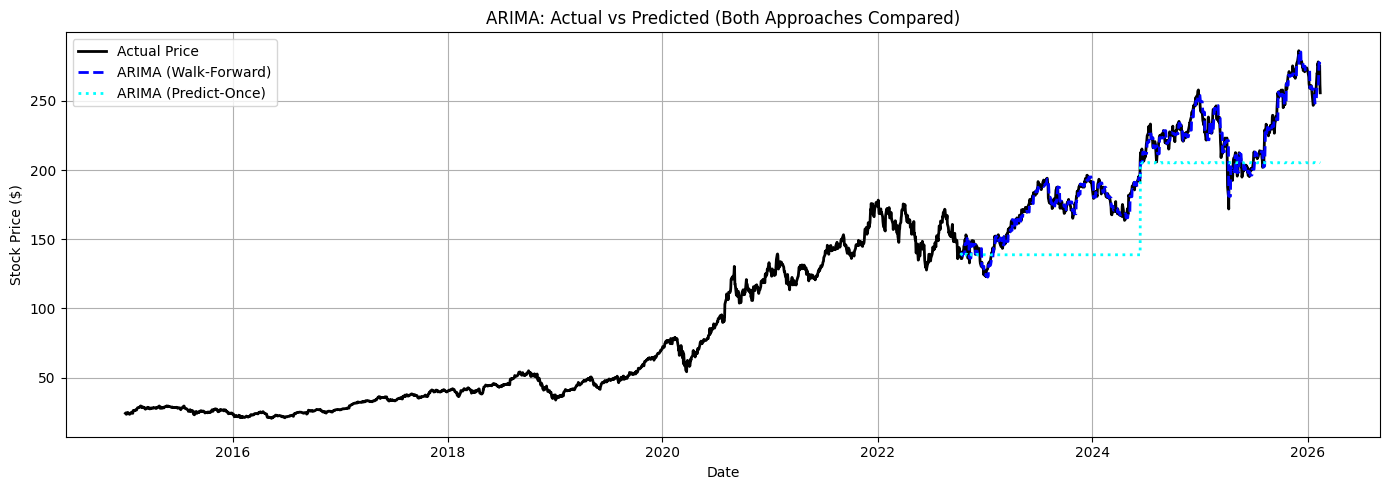

In [6]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

series_train = train_df['y'].values
series_val = val_df['y'].values
series_trainval = pd.concat([train_df['y'], val_df['y']]).values
series_test = test_df['y'].values
test_dates = test_df['Date'].reset_index(drop=True)
train_dates = train_df['Date'].reset_index(drop=True)
val_dates = val_df['Date'].reset_index(drop=True)

# ---------- ARIMA Example with Extended Grid ----------
# Expanded grid for better model selection
arima_grid = [
    (1,1,1), (2,1,1), (2,1,2), (3,1,2),
    (1,1,2), (3,1,1), (1,1,3), (2,1,3),
    (0,1,1), (0,1,2), (1,1,0), (2,1,0)
]
best_order, best_val_rmse = None, np.inf

for order in arima_grid:
    try:
        m = ARIMA(series_train, order=order).fit()
        pred_val = m.forecast(steps=len(series_val))
        score = rmse(series_val, pred_val)
        if score < best_val_rmse:
            best_val_rmse = score
            best_order = order
    except Exception:
        pass

print(f"Best ARIMA order selected: {best_order}")

# ---------- Walk-Forward Predictions (Better than one-shot forecasts) ----------
# For validation: rolling predictions with weekly updates
val_rolling_history = list(series_train)
val_rolling_preds = []
chunk = 5  # refit every week

for i in range(0, len(series_val), chunk):
    horizon = min(chunk, len(series_val) - i)
    m = ARIMA(val_rolling_history, order=best_order).fit()
    p = m.forecast(steps=horizon)
    val_rolling_preds.extend(p)
    val_rolling_history.extend(series_val[i:i+horizon])

val_rolling_preds = np.asarray(val_rolling_preds)
report_metrics(f"ARIMA Validation (walk-forward, order={best_order})", series_val, val_rolling_preds)

# For test: rolling predictions with weekly updates
test_rolling_history = list(series_trainval)
test_rolling_preds = []

for i in range(0, len(series_test), chunk):
    horizon = min(chunk, len(series_test) - i)
    m = ARIMA(test_rolling_history, order=best_order).fit()
    p = m.forecast(steps=horizon)
    test_rolling_preds.extend(p)
    test_rolling_history.extend(series_test[i:i+horizon])

test_rolling_preds = np.asarray(test_rolling_preds)
report_metrics(f"ARIMA Test (walk-forward, order={best_order})", series_test, test_rolling_preds)

# ---------- Predict-Once Approach (for comparison) ----------
print("\n--- Predict-Once Approach (single model, no retraining) ---")
# Train on train, predict validation
arima_once_val_model = ARIMA(series_train, order=best_order).fit()
arima_once_val_preds = arima_once_val_model.forecast(steps=len(series_val))
# Train on train+val, predict test
arima_once_test_model = ARIMA(series_trainval, order=best_order).fit()
arima_once_test_preds = arima_once_test_model.forecast(steps=len(series_test))
# Combine for full predict-once predictions
arima_once_all_preds = np.concatenate([arima_once_val_preds, arima_once_test_preds])
report_metrics(f"ARIMA Test (predict-once, order={best_order})", series_test, arima_once_test_preds)

# ---------- ARIMA Plot: Both Approaches ----------
plt.figure(figsize=(14, 5))

# Combine all dates and actual values
all_dates = pd.concat([train_dates, val_dates, test_dates]).reset_index(drop=True)
all_actuals = np.concatenate([series_train, series_val, series_test])

# Combine validation and test predictions for both approaches
pred_dates = pd.concat([val_dates, test_dates]).reset_index(drop=True)
all_preds = np.concatenate([val_rolling_preds, test_rolling_preds])

# Plot all three lines: actual, walk-forward, and predict-once
plt.plot(all_dates, all_actuals, label='Actual Price', color='black', linewidth=2)
plt.plot(pred_dates, all_preds, label='ARIMA (Walk-Forward)', color='blue', linewidth=2, linestyle='--')
plt.plot(pred_dates, arima_once_all_preds, label='ARIMA (Predict-Once)', color='cyan', linewidth=2, linestyle=':')

plt.title('ARIMA: Actual vs Predicted (Both Approaches Compared)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Best SARIMA config: order=(1, 1, 1), seasonal=(0, 1, 1, 5)
SARIMA Validation (walk-forward)
  MAE : 3.3055
  RMSE: 4.2901
  MAPE: 2.01%
SARIMA Test (walk-forward)
  MAE : 4.9121
  RMSE: 6.9887
  MAPE: 2.17%

--- Predict-Once Approach (single model, no retraining) ---
SARIMA Test (predict-once)
  MAE : 19.8242
  RMSE: 22.9609
  MAPE: 8.35%


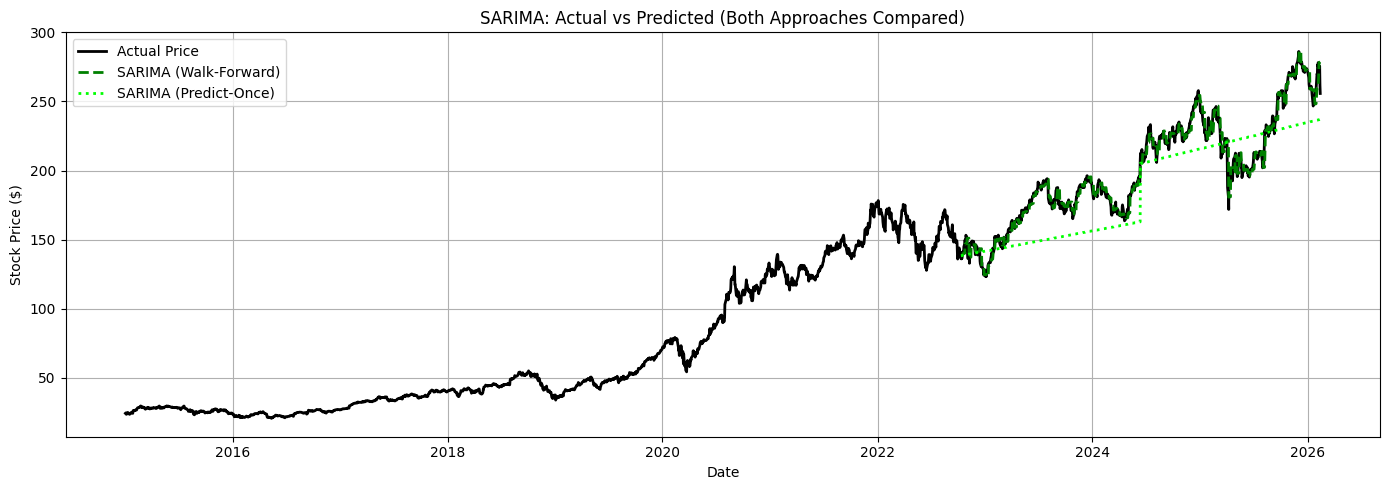

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ---------- SARIMA Example with Extended Grid ----------
sarima_grid = [
    ((1,1,1), (0,1,1,5)),
    ((1,1,1), (1,1,1,5)),
    ((2,1,1), (1,1,1,5)),
    ((2,1,2), (1,1,1,5)),
    ((1,1,2), (1,1,1,5)),
    ((0,1,1), (0,1,1,5)),
    ((1,1,0), (1,1,0,5)),
]

best_cfg, best_val_rmse = None, np.inf
for order, seas in sarima_grid:
    try:
        m = SARIMAX(series_train, order=order, seasonal_order=seas,
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        pred_val = m.forecast(steps=len(series_val))
        score = rmse(series_val, pred_val)
        if score < best_val_rmse:
            best_val_rmse = score
            best_cfg = (order, seas)
    except Exception:
        pass

(order_best, seas_best) = best_cfg
print(f"Best SARIMA config: order={order_best}, seasonal={seas_best}")

# ---------- Walk-Forward Predictions for SARIMA ----------
# For validation: rolling predictions
sarima_val_history = list(series_train)
sarima_val_preds = []
chunk = 5  # refit every week

for i in range(0, len(series_val), chunk):
    horizon = min(chunk, len(series_val) - i)
    m = SARIMAX(sarima_val_history, order=order_best, seasonal_order=seas_best,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    p = m.forecast(steps=horizon)
    sarima_val_preds.extend(p)
    sarima_val_history.extend(series_val[i:i+horizon])

sarima_val_preds = np.asarray(sarima_val_preds)
report_metrics(f"SARIMA Validation (walk-forward)", series_val, sarima_val_preds)

# For test: rolling predictions
sarima_test_history = list(series_trainval)
sarima_test_preds = []

for i in range(0, len(series_test), chunk):
    horizon = min(chunk, len(series_test) - i)
    m = SARIMAX(sarima_test_history, order=order_best, seasonal_order=seas_best,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    p = m.forecast(steps=horizon)
    sarima_test_preds.extend(p)
    sarima_test_history.extend(series_test[i:i+horizon])

sarima_test_preds = np.asarray(sarima_test_preds)
report_metrics(f"SARIMA Test (walk-forward)", series_test, sarima_test_preds)

# ---------- Predict-Once Approach (for comparison) ----------
print("\n--- Predict-Once Approach (single model, no retraining) ---")
# Train on train, predict validation
sarima_once_val_model = SARIMAX(series_train, order=order_best, seasonal_order=seas_best,
                                 enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
sarima_once_val_preds = sarima_once_val_model.forecast(steps=len(series_val))
# Train on train+val, predict test
sarima_once_test_model = SARIMAX(series_trainval, order=order_best, seasonal_order=seas_best,
                                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
sarima_once_test_preds = sarima_once_test_model.forecast(steps=len(series_test))
# Combine for full predict-once predictions
sarima_once_all_preds = np.concatenate([sarima_once_val_preds, sarima_once_test_preds])
report_metrics(f"SARIMA Test (predict-once)", series_test, sarima_once_test_preds)

# ---------- SARIMA Plot: Both Approaches ----------
plt.figure(figsize=(14, 5))

# Combine all dates and actual values
all_dates = pd.concat([train_dates, val_dates, test_dates]).reset_index(drop=True)
all_actuals = np.concatenate([series_train, series_val, series_test])

# Combine validation and test predictions for both approaches
pred_dates = pd.concat([val_dates, test_dates]).reset_index(drop=True)
all_preds = np.concatenate([sarima_val_preds, sarima_test_preds])

# Plot all three lines: actual, walk-forward, and predict-once
plt.plot(all_dates, all_actuals, label='Actual Price', color='black', linewidth=2)
plt.plot(pred_dates, all_preds, label='SARIMA (Walk-Forward)', color='green', linewidth=2, linestyle='--')
plt.plot(pred_dates, sarima_once_all_preds, label='SARIMA (Predict-Once)', color='lime', linewidth=2, linestyle=':')

plt.title('SARIMA: Actual vs Predicted (Both Approaches Compared)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

ETS (Exponential Smoothing) - How It Works:
Think of ETS like a smart calculator that gives more weight to recent data.

🔹 LEVEL: The 'baseline' price right now (like today's average)
🔹 TREND: Is the price going up or down? (like climbing stairs vs going down)
🔹 SEASONALITY: Repeating patterns (like 'Mondays are usually higher')

Instead of treating all history equally, ETS 'forgets' old data gradually.
Yesterday matters more than last month. Last week matters more than last year.
This makes it great for data where recent behavior is most important!

Best ETS configuration selected: {'trend': 'mul', 'seasonal': 'add', 'seasonal_periods': 5}

ETS Validation (walk-forward)
  MAE : 3.2869
  RMSE: 4.2982
  MAPE: 2.00%
ETS Test (walk-forward)
  MAE : 4.8900
  RMSE: 6.9848
  MAPE: 2.16%

--- Predict-Once Approach (single model, no retraining) ---
ETS Test (predict-once)
  MAE : 16.6358
  RMSE: 21.0818
  MAPE: 7.56%


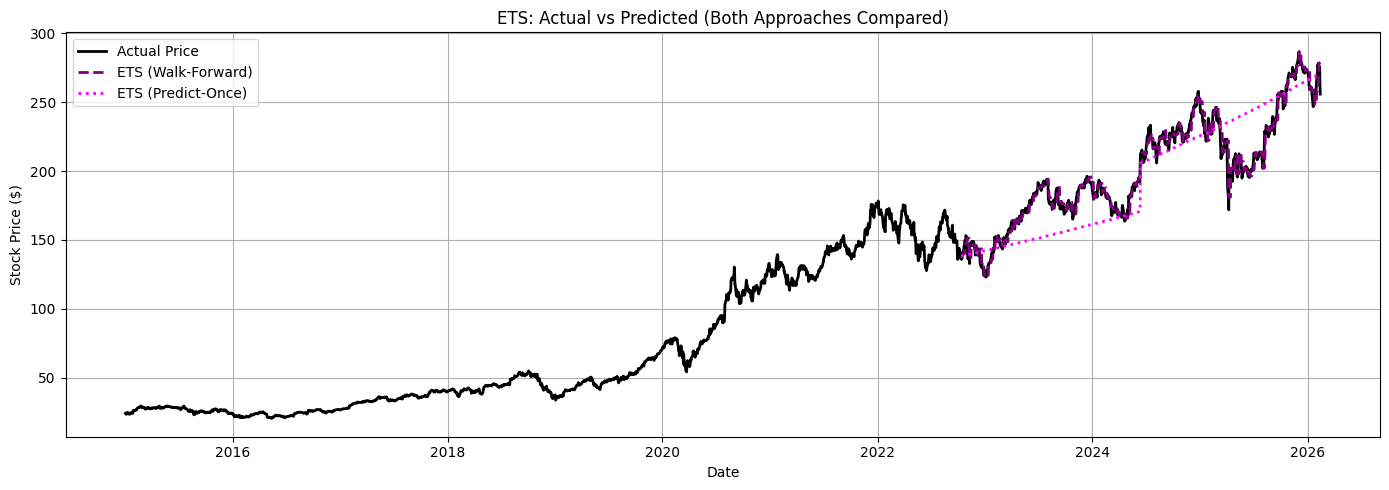

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

print("=" * 60)
print("ETS (Exponential Smoothing) - How It Works:")
print("=" * 60)
print("Think of ETS like a smart calculator that gives more weight to recent data.")
print("")
print("🔹 LEVEL: The 'baseline' price right now (like today's average)")
print("🔹 TREND: Is the price going up or down? (like climbing stairs vs going down)")
print("🔹 SEASONALITY: Repeating patterns (like 'Mondays are usually higher')")
print("")
print("Instead of treating all history equally, ETS 'forgets' old data gradually.")
print("Yesterday matters more than last month. Last week matters more than last year.")
print("This makes it great for data where recent behavior is most important!")
print("=" * 60)
print()

# ---------- ETS Example with Extended Grid ----------
ets_candidates = [
    dict(trend='add', seasonal=None),
    dict(trend='add', seasonal='add', seasonal_periods=5),
    dict(trend='mul', seasonal='add', seasonal_periods=5),
    dict(trend='add', seasonal='mul', seasonal_periods=5),
    dict(trend='mul', seasonal='mul', seasonal_periods=5),
    dict(trend=None, seasonal='add', seasonal_periods=5),
]

best_ets_cfg, best_val_rmse = None, np.inf
for cfg in ets_candidates:
    try:
        m = ExponentialSmoothing(series_train, **cfg).fit(optimized=True)
        pred_val = m.forecast(len(series_val))
        score = rmse(series_val, pred_val)
        if score < best_val_rmse:
            best_val_rmse = score
            best_ets_cfg = cfg
    except Exception:
        pass

print(f"Best ETS configuration selected: {best_ets_cfg}")
print()

# ---------- Walk-Forward Predictions for ETS ----------
# For validation: rolling predictions
ets_val_history = list(series_train)
ets_val_preds = []
chunk = 5  # refit every week

for i in range(0, len(series_val), chunk):
    horizon = min(chunk, len(series_val) - i)
    try:
        m = ExponentialSmoothing(ets_val_history, **best_ets_cfg).fit(optimized=True)
        p = m.forecast(steps=horizon)
        ets_val_preds.extend(p)
        ets_val_history.extend(series_val[i:i+horizon])
    except Exception:
        # Fallback if model fails
        ets_val_preds.extend([ets_val_history[-1]] * horizon)
        ets_val_history.extend(series_val[i:i+horizon])

ets_val_preds = np.asarray(ets_val_preds)
report_metrics(f"ETS Validation (walk-forward)", series_val, ets_val_preds)

# For test: rolling predictions
ets_test_history = list(series_trainval)
ets_test_preds = []

for i in range(0, len(series_test), chunk):
    horizon = min(chunk, len(series_test) - i)
    try:
        m = ExponentialSmoothing(ets_test_history, **best_ets_cfg).fit(optimized=True)
        p = m.forecast(steps=horizon)
        ets_test_preds.extend(p)
        ets_test_history.extend(series_test[i:i+horizon])
    except Exception:
        # Fallback if model fails
        ets_test_preds.extend([ets_test_history[-1]] * horizon)
        ets_test_history.extend(series_test[i:i+horizon])

ets_test_preds = np.asarray(ets_test_preds)
report_metrics(f"ETS Test (walk-forward)", series_test, ets_test_preds)

# ---------- Predict-Once Approach (for comparison) ----------
print("\n--- Predict-Once Approach (single model, no retraining) ---")
# Train on train, predict validation
try:
    ets_once_val_model = ExponentialSmoothing(series_train, **best_ets_cfg).fit(optimized=True)
    ets_once_val_preds = ets_once_val_model.forecast(steps=len(series_val))
except Exception as e:
    print(f"Predict-once validation failed: {e}")
    ets_once_val_preds = np.full(len(series_val), series_train[-1])
# Train on train+val, predict test
try:
    ets_once_test_model = ExponentialSmoothing(series_trainval, **best_ets_cfg).fit(optimized=True)
    ets_once_test_preds = ets_once_test_model.forecast(steps=len(series_test))
    report_metrics(f"ETS Test (predict-once)", series_test, ets_once_test_preds)
except Exception as e:
    print(f"Predict-once test failed: {e}")
    ets_once_test_preds = np.full(len(series_test), series_trainval[-1])
# Combine for full predict-once predictions
ets_once_all_preds = np.concatenate([ets_once_val_preds, ets_once_test_preds])

# ---------- ETS Plot: Both Approaches ----------
plt.figure(figsize=(14, 5))

# Combine all dates and actual values
all_dates = pd.concat([train_dates, val_dates, test_dates]).reset_index(drop=True)
all_actuals = np.concatenate([series_train, series_val, series_test])

# Combine validation and test predictions for both approaches
pred_dates = pd.concat([val_dates, test_dates]).reset_index(drop=True)
all_preds = np.concatenate([ets_val_preds, ets_test_preds])

# Plot all three lines: actual, walk-forward, and predict-once
plt.plot(all_dates, all_actuals, label='Actual Price', color='black', linewidth=2)
plt.plot(pred_dates, all_preds, label='ETS (Walk-Forward)', color='purple', linewidth=2, linestyle='--')
plt.plot(pred_dates, ets_once_all_preds, label='ETS (Predict-Once)', color='magenta', linewidth=2, linestyle=':')

plt.title('ETS: Actual vs Predicted (Both Approaches Compared)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 2) Machine Learning Methods

These methods turn forecasting into a "guess the next number" game by learning from patterns in past data.

### Method 4: XGBoost
**What it does:** Think of this as creating a super-smart spreadsheet where each row has info like "what was the price yesterday?", "what was the average over the last week?", "is it a Monday?". Then XGBoost learns which combinations of these clues are useful for predicting tomorrow's price.

It builds many simple prediction rules (like decision trees) and combines them. Each new rule tries to fix the mistakes of the previous ones.

**When it works:** Amazing when there are complex patterns that depend on multiple things at once (like "prices drop on Mondays UNLESS last week was really volatile").
**When it fails:** Can get too obsessed with tiny patterns in training data that don't actually matter.

### Method 5: Prophet
**What it does:** Created by Facebook to forecast things like daily active users. It breaks your data into simple pieces:
- An overall trend (are things generally going up or down?)
- Seasonal patterns (does it spike every weekend?)
- Special events (holidays, product launches, etc.)
- Random noise

Then it adds these pieces back together to make predictions.

**When it works:** Great for business data with clear trends and patterns, especially when you have holidays or special events.
**When it fails:** Struggles with data that's super unpredictable or changes behavior suddenly.

- Never use information from the future to predict the past

### How we test these- For XGBoost, we try different settings and validate carefully
- Always train on past data and test on future data (never mix them up!)

Best XGBoost config: {'max_depth': 3, 'learning_rate': 0.05, 'min_child_weight': 3, 'gamma': 0.0}

Using walk-forward approach (retraining weekly for better accuracy)...
XGBoost Validation (walk-forward)
  MAE : 2.5945
  RMSE: 3.6771
  MAPE: 1.54%
XGBoost Test (walk-forward)
  MAE : 4.3172
  RMSE: 5.8556
  MAPE: 1.86%

--- Predict-Once Approach (single model, no retraining) ---
XGBoost Test (predict-once)
  MAE : 34.5790
  RMSE: 41.5169
  MAPE: 14.08%


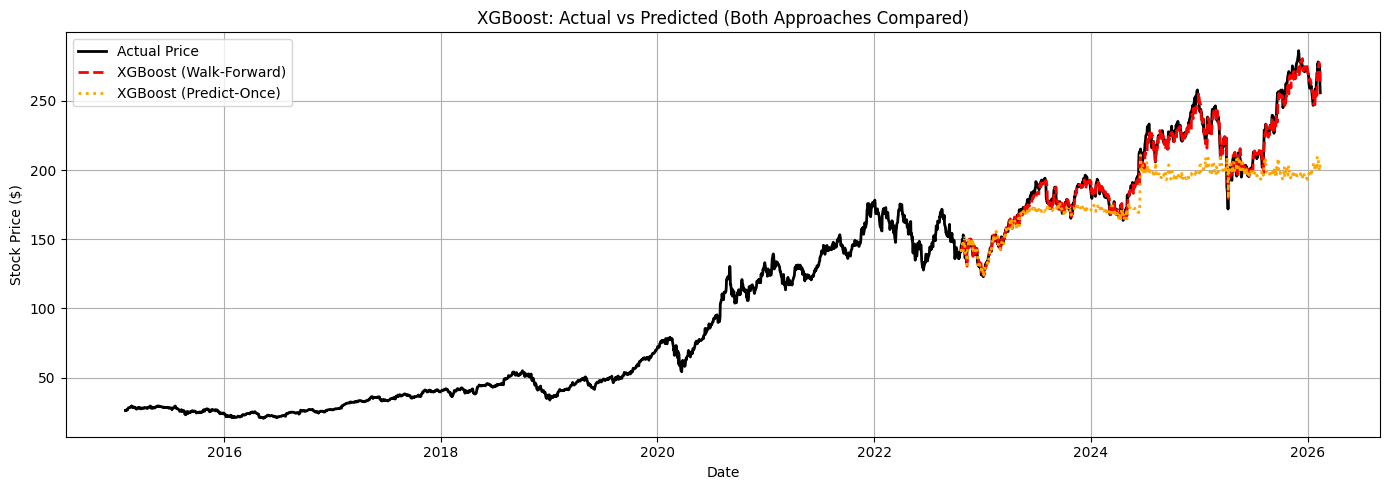


Top 10 XGBoost features (what the model pays attention to):
lag_1           0.471523
lag_2           0.242854
roll_mean_5     0.233982
lag_3           0.024242
roll_mean_20    0.013736
roll_mean_10    0.010128
lag_5           0.001602
lag_20          0.000892
lag_10          0.000627
Volume          0.000105
dtype: float32

💡 Interpretation: lag_1 = yesterday's price, roll_mean_5 = 5-day average, etc.

✨ Walk-forward approach: Model is retrained every 5 days with new data!
   This helps capture changing market conditions better than a single model.


In [ ]:
from xgboost import XGBRegressor

feat_df = make_lag_features(df)
feature_cols = [c for c in feat_df.columns if c not in ['Date', 'y']]

n2 = len(feat_df)
tr2 = int(n2 * 0.70)
va2 = int(n2 * 0.85)

train_feat = feat_df.iloc[:tr2]
val_feat = feat_df.iloc[tr2:va2]
test_feat = feat_df.iloc[va2:]

X_train, y_train = train_feat[feature_cols], train_feat['y']
X_val, y_val = val_feat[feature_cols], val_feat['y']
X_test, y_test = test_feat[feature_cols], test_feat['y']
val_dates_xgb = val_feat['Date'].reset_index(drop=True)
test_dates_xgb = test_feat['Date'].reset_index(drop=True)

# ---------- XGBoost Example with Improved Parameters ----------
# Expanded grid with more configurations for better performance
example_grid = [
    {'max_depth': 3, 'learning_rate': 0.05, 'min_child_weight': 3, 'gamma': 0.0},
    {'max_depth': 4, 'learning_rate': 0.05, 'min_child_weight': 3, 'gamma': 0.0},
    {'max_depth': 4, 'learning_rate': 0.03, 'min_child_weight': 5, 'gamma': 0.1},
    {'max_depth': 5, 'learning_rate': 0.03, 'min_child_weight': 5, 'gamma': 0.1},
    {'max_depth': 3, 'learning_rate': 0.07, 'min_child_weight': 2, 'gamma': 0.0},
]

best_ex_cfg, best_ex_rmse, best_ex_model = None, np.inf, None
for cfg in example_grid:
    model = XGBRegressor(
        n_estimators=1500,
        max_depth=cfg['max_depth'],
        learning_rate=cfg['learning_rate'],
        min_child_weight=cfg['min_child_weight'],
        gamma=cfg['gamma'],
        subsample=0.85,
        colsample_bytree=0.85,
        reg_alpha=0.1,
        reg_lambda=1.5,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    pred = model.predict(X_val)
    score = rmse(y_val, pred)
    if score < best_ex_rmse:
        best_ex_rmse, best_ex_cfg, best_ex_model = score, cfg, model

print(f"Best XGBoost config: {best_ex_cfg}")

# ---------- Walk-Forward Predictions for XGBoost (Like ARIMA/SARIMA) ----------
# For validation: rolling predictions with weekly updates
print("\nUsing walk-forward approach (retraining weekly for better accuracy)...")

# Validation walk-forward
X_val_history = X_train.copy()
y_val_history = y_train.copy()
xgb_val_wf_preds = []
chunk = 5  # refit every week (5 trading days)

for i in range(0, len(X_val), chunk):
    horizon = min(chunk, len(X_val) - i)
    
    # Train on accumulated history
    model = XGBRegressor(
        n_estimators=800,
        max_depth=best_ex_cfg['max_depth'],
        learning_rate=best_ex_cfg['learning_rate'],
        min_child_weight=best_ex_cfg['min_child_weight'],
        gamma=best_ex_cfg['gamma'],
        subsample=0.85,
        colsample_bytree=0.85,
        reg_alpha=0.1,
        reg_lambda=1.5,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    model.fit(X_val_history, y_val_history, verbose=False)
    
    # Predict next chunk
    X_chunk = X_val.iloc[i:i+horizon]
    y_chunk = y_val.iloc[i:i+horizon]
    preds = model.predict(X_chunk)
    xgb_val_wf_preds.extend(preds)
    
    # Update history with actual values
    X_val_history = pd.concat([X_val_history, X_chunk])
    y_val_history = pd.concat([y_val_history, y_chunk])

xgb_val_wf_preds = np.array(xgb_val_wf_preds)
report_metrics(f"XGBoost Validation (walk-forward)", y_val, xgb_val_wf_preds)

# Test walk-forward
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])
X_test_history = X_trainval.copy()
y_test_history = y_trainval.copy()
xgb_test_wf_preds = []

for i in range(0, len(X_test), chunk):
    horizon = min(chunk, len(X_test) - i)
    
    # Train on accumulated history
    model = XGBRegressor(
        n_estimators=800,
        max_depth=best_ex_cfg['max_depth'],
        learning_rate=best_ex_cfg['learning_rate'],
        min_child_weight=best_ex_cfg['min_child_weight'],
        gamma=best_ex_cfg['gamma'],
        subsample=0.85,
        colsample_bytree=0.85,
        reg_alpha=0.1,
        reg_lambda=1.5,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    model.fit(X_test_history, y_test_history, verbose=False)
    
    # Predict next chunk
    X_chunk = X_test.iloc[i:i+horizon]
    y_chunk = y_test.iloc[i:i+horizon]
    preds = model.predict(X_chunk)
    xgb_test_wf_preds.extend(preds)
    
    # Update history with actual values
    X_test_history = pd.concat([X_test_history, X_chunk])
    y_test_history = pd.concat([y_test_history, y_chunk])

xgb_test_wf_preds = np.array(xgb_test_wf_preds)
report_metrics("XGBoost Test (walk-forward)", y_test, xgb_test_wf_preds)

# Store final model with feature importances
xgb_final = model  # Last trained model

# ---------- Predict-Once Approach (for comparison) ----------
print("\n--- Predict-Once Approach (single model, no retraining) ---")
# Train on train, predict validation
xgb_once_val = XGBRegressor(
    n_estimators=800,
    max_depth=best_ex_cfg['max_depth'],
    learning_rate=best_ex_cfg['learning_rate'],
    min_child_weight=best_ex_cfg['min_child_weight'],
    gamma=best_ex_cfg['gamma'],
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=1.5,
    objective='reg:squarederror',
    tree_method='hist',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_once_val.fit(X_train, y_train, verbose=False)
xgb_once_val_preds = xgb_once_val.predict(X_val)
# Train on train+val, predict test
xgb_once_test = XGBRegressor(
    n_estimators=800,
    max_depth=best_ex_cfg['max_depth'],
    learning_rate=best_ex_cfg['learning_rate'],
    min_child_weight=best_ex_cfg['min_child_weight'],
    gamma=best_ex_cfg['gamma'],
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=1.5,
    objective='reg:squarederror',
    tree_method='hist',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_once_test.fit(X_trainval, y_trainval, verbose=False)
xgb_once_test_preds = xgb_once_test.predict(X_test)
# Combine for full predict-once predictions
xgb_once_all_preds = np.concatenate([xgb_once_val_preds, xgb_once_test_preds])
report_metrics("XGBoost Test (predict-once)", y_test, xgb_once_test_preds)

# ---------- XGBoost Plot: Both Approaches ----------
plt.figure(figsize=(14, 5))

# Combine all dates and actual values
train_dates_xgb = train_feat['Date'].reset_index(drop=True)
all_dates_xgb = pd.concat([train_dates_xgb, val_dates_xgb, test_dates_xgb]).reset_index(drop=True)
all_actuals_xgb = np.concatenate([y_train.values, y_val.values, y_test.values])

# Combine validation and test predictions for both approaches
pred_dates_xgb = pd.concat([val_dates_xgb, test_dates_xgb]).reset_index(drop=True)
all_preds_xgb = np.concatenate([xgb_val_wf_preds, xgb_test_wf_preds])

# Plot all three lines: actual, walk-forward, and predict-once
plt.plot(all_dates_xgb, all_actuals_xgb, label='Actual Price', color='black', linewidth=2)
plt.plot(pred_dates_xgb, all_preds_xgb, label='XGBoost (Walk-Forward)', color='red', linewidth=2, linestyle='--')
plt.plot(pred_dates_xgb, xgb_once_all_preds, label='XGBoost (Predict-Once)', color='orange', linewidth=2, linestyle=':')

plt.title('XGBoost: Actual vs Predicted (Both Approaches Compared)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Optional interpretability: top feature importances
imp = pd.Series(xgb_final.feature_importances_, index=feature_cols).sort_values(ascending=False).head(10)
print('\nTop 10 XGBoost features (what the model pays attention to):')
print(imp)
print()
print("💡 Interpretation: lag_1 = yesterday's price, roll_mean_5 = 5-day average, etc.")
print("\n✨ Walk-forward approach: Model is retrained every 5 days with new data!")
print("   This helps capture changing market conditions better than a single model.")

In [ ]:
from prophet import Prophet

prophet_df = df[['Date', 'y', 'Volume']].rename(columns={'Date': 'ds'}).copy()
prophet_df['log_volume'] = np.log1p(prophet_df['Volume'])

n3 = len(prophet_df)
tr3 = int(n3 * 0.70)
va3 = int(n3 * 0.85)

pr_train = prophet_df.iloc[:tr3].copy()
pr_val = prophet_df.iloc[tr3:va3].copy()
pr_test = prophet_df.iloc[va3:].copy()

# ---------- Prophet Example ----------
# Tune changepoint/seasonality configuration on validation.
example_grid = [
    {'changepoint_prior_scale': 0.03, 'seasonality_mode': 'additive'},
    {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'},
    {'changepoint_prior_scale': 0.10, 'seasonality_mode': 'additive'},
    {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'},
]

best_ex_cfg, best_ex_rmse = None, np.inf
for cfg in example_grid:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cfg['changepoint_prior_scale'],
        seasonality_mode=cfg['seasonality_mode'],
    )
    model.fit(pr_train[['ds', 'y']])
    pred_val = model.predict(pr_val[['ds']])['yhat'].values
    score = rmse(pr_val['y'].values, pred_val)
    if score < best_ex_rmse:
        best_ex_rmse = score
        best_ex_cfg = cfg

pr_ex = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_ex_cfg['changepoint_prior_scale'],
    seasonality_mode=best_ex_cfg['seasonality_mode'],
)
pr_ex.fit(pr_train[['ds', 'y']])
pr_ex_val_forecast = pr_ex.predict(pr_val[['ds']])['yhat'].values
report_metrics(f"Prophet Example (validation, tuned={best_ex_cfg})", pr_val['y'].values, pr_ex_val_forecast)

pr_ex_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_ex_cfg['changepoint_prior_scale'],
    seasonality_mode=best_ex_cfg['seasonality_mode'],
)
pr_ex_full.fit(pd.concat([pr_train, pr_val])[['ds', 'y']])
pr_ex_test_pred = pr_ex_full.predict(pr_test[['ds']])['yhat'].values
report_metrics("Prophet Example (test)", pr_test['y'].values, pr_ex_test_pred)

# ---------- Prophet Project ----------
# Add exogenous regressor and retune.
project_grid = [
    {'changepoint_prior_scale': 0.03, 'seasonality_mode': 'additive'},
    {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'},
    {'changepoint_prior_scale': 0.10, 'seasonality_mode': 'multiplicative'},
]

best_proj_cfg, best_proj_rmse = None, np.inf
for cfg in project_grid:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cfg['changepoint_prior_scale'],
        seasonality_mode=cfg['seasonality_mode'],
    )
    model.add_regressor('log_volume')
    model.fit(pr_train[['ds', 'y', 'log_volume']])
    pred_val = model.predict(pr_val[['ds', 'log_volume']])['yhat'].values
    score = rmse(pr_val['y'].values, pred_val)
    if score < best_proj_rmse:
        best_proj_rmse = score
        best_proj_cfg = cfg

print(f"Best Prophet config: {best_proj_cfg}")

# ---------- Walk-Forward Predictions for Prophet ----------
print("\nUsing walk-forward approach (retraining weekly for better accuracy)...")

# For validation: rolling predictions with weekly updates
pr_val_history = pr_train.copy()
prophet_val_preds = []
chunk = 5  # refit every week (5 trading days)

for i in range(0, len(pr_val), chunk):
    horizon = min(chunk, len(pr_val) - i)
    
    # Train on accumulated history
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=best_proj_cfg['changepoint_prior_scale'],
        seasonality_mode=best_proj_cfg['seasonality_mode'],
    )
    model.add_regressor('log_volume')
    model.fit(pr_val_history[['ds', 'y', 'log_volume']])
    
    # Predict next chunk
    future_df = pr_val.iloc[i:i+horizon][['ds', 'log_volume']].copy()
    preds = model.predict(future_df)['yhat'].values
    prophet_val_preds.extend(preds)
    
    # Update history with actual values
    pr_val_history = pd.concat([pr_val_history, pr_val.iloc[i:i+horizon]])

prophet_val_preds = np.array(prophet_val_preds)
report_metrics("Prophet Validation (walk-forward)", pr_val['y'].values, prophet_val_preds)

# For test: rolling predictions
pr_trainval = pd.concat([pr_train, pr_val])
pr_test_history = pr_trainval.copy()
prophet_test_preds = []

for i in range(0, len(pr_test), chunk):
    horizon = min(chunk, len(pr_test) - i)
    
    # Train on accumulated history
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=best_proj_cfg['changepoint_prior_scale'],
        seasonality_mode=best_proj_cfg['seasonality_mode'],
    )
    model.add_regressor('log_volume')
    model.fit(pr_test_history[['ds', 'y', 'log_volume']])
    
    # Predict next chunk
    future_df = pr_test.iloc[i:i+horizon][['ds', 'log_volume']].copy()
    preds = model.predict(future_df)['yhat'].values
    prophet_test_preds.extend(preds)
    
    # Update history with actual values
    pr_test_history = pd.concat([pr_test_history, pr_test.iloc[i:i+horizon]])

prophet_test_preds = np.array(prophet_test_preds)
report_metrics("Prophet Test (walk-forward)", pr_test['y'].values, prophet_test_preds)

# ---------- Predict-Once Approach (for comparison) ----------
print("\n--- Predict-Once Approach (single model, no retraining) ---")
# Train on train, predict validation
prophet_once_val = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_proj_cfg['changepoint_prior_scale'],
    seasonality_mode=best_proj_cfg['seasonality_mode'],
)
prophet_once_val.add_regressor('log_volume')
prophet_once_val.fit(pr_train[['ds', 'y', 'log_volume']])
prophet_once_val_preds = prophet_once_val.predict(pr_val[['ds', 'log_volume']])['yhat'].values

# Train on train+val, predict test
prophet_once_test = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_proj_cfg['changepoint_prior_scale'],
    seasonality_mode=best_proj_cfg['seasonality_mode'],
)
prophet_once_test.add_regressor('log_volume')
prophet_once_test.fit(pr_trainval[['ds', 'y', 'log_volume']])
prophet_once_test_preds = prophet_once_test.predict(pr_test[['ds', 'log_volume']])['yhat'].values
# Combine for full predict-once predictions
prophet_once_all_preds = np.concatenate([prophet_once_val_preds, prophet_once_test_preds])
report_metrics("Prophet Test (predict-once)", pr_test['y'].values, prophet_once_test_preds)

# ---------- Prophet Plot: Both Approaches ----------
plt.figure(figsize=(14, 5))

# Combine all dates and actual values
all_dates_pr = pd.concat([pr_train['ds'], pr_val['ds'], pr_test['ds']]).reset_index(drop=True)
all_actuals_pr = np.concatenate([pr_train['y'].values, pr_val['y'].values, pr_test['y'].values])

# Combine validation and test predictions for both approaches
pred_dates_pr = pd.concat([pr_val['ds'], pr_test['ds']]).reset_index(drop=True)
all_preds_pr = np.concatenate([prophet_val_preds, prophet_test_preds])

# Plot all three lines: actual, walk-forward, and predict-once
plt.plot(all_dates_pr, all_actuals_pr, label='Actual Price', color='black', linewidth=2)
plt.plot(pred_dates_pr, all_preds_pr, label='Prophet (Walk-Forward)', color='darkorange', linewidth=2, linestyle='--')
plt.plot(pred_dates_pr, prophet_once_all_preds, label='Prophet (Predict-Once)', color='gold', linewidth=2, linestyle=':')

plt.title('Prophet: Actual vs Predicted (Both Approaches Compared)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Importing plotly failed. Interactive plots will not work.
22:48:11 - cmdstanpy - INFO - Chain [1] start processing
22:48:12 - cmdstanpy - INFO - Chain [1] done processing
22:48:13 - cmdstanpy - INFO - Chain [1] start processing
22:48:13 - cmdstanpy - INFO - Chain [1] done processing
22:48:14 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

## 3) Deep Learning & Neural Networks

These are the "brain-inspired" models that learn complex patterns by looking at lots of examples.

### Method 6: DeepAR
**What it does:** Instead of just saying "tomorrow's price will be $150", DeepAR says "I'm pretty sure it'll be between $145 and $155, with $150 being most likely." It's like giving you a range of possibilities instead of one guess.

It uses a type of neural network (RNN) that reads through your time series like reading a story - understanding what came before helps predict what's next.

**Why it's cool:** Tells you not just what might happen, but how confident it is. Super useful when you need to know the risk!

### Method 7: TFT (Temporal Fusion Transformer)
**What it does:** This is like having an assistant that can focus on the most important parts of your data. It uses "attention" to figure out which past days matter most for today's prediction, and which extra info (like trading volume) is actually useful.

**Why it's cool:** Not only accurate, but it can tell you WHY it made its prediction ("I focused heavily on last Tuesday because...").

### Method 8: N-BEATS / N-HiTS
**What it does:** Purpose-built for forecasting (not borrowed from image recognition or language!). These stack multiple layers that each try to capture different patterns - some catch fast changes, others catch slow trends.

**Why it's cool:** Really fast and accurate, especially good for simple single-number predictions.

### Tips for running on regular laptops
- Don't look at too much history at once

- Don't train for too many steps- Start simple, then add complexity if needed

Seed set to 1



🧠 DEEP LEARNING TRAINING PHASE
Training all neural network models first, then plotting results...

METHOD 6: DeepAR (Probabilistic Deep Learning)
📊 Training data: 1957 train + 419 validation = 2376 total points
🎯 Prediction horizon: 420 days
⚙️  Configuration: input_size=60, max_steps=120, learning_rate=1e-3
🚀 Starting DeepAR training...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ DistributionLoss │      5 │ train │     0 │
│ 1 │ valid_loss   │ MAE              │      0 │ train │     0 │
│ 2 │ padder_train │ ConstantPad1d    │      0 │ train │     0 │
│ 3 │ scaler       │ TemporalNorm     │      0 │ train │     0 │
│ 4 │ hist_encoder │ LSTM             │  199 K │ train │     0 │
│ 5 │ decoder      │ Decoder          │    387 │ train │     0 │
└───┴──────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 199 K                                                                                            
Non-trainable params: 5                                                                                            
Total params: 199 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_steps=120` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


✅ DeepAR training complete!


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


DeepAR (test)
  MAE : 24.8505
  RMSE: 31.6515
  MAPE: 10.06%

METHOD 7: TFT (Temporal Fusion Transformer)
📊 Training data: 2376 total points
🎯 Prediction horizon: 420 days
⚙️  Configuration: input_size=80, max_steps=150, hidden_size=64
🚀 Starting TFT training...


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                    ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss                    │ MAE                      │      0 │ train │     0 │
│ 1 │ padder_train            │ ConstantPad1d            │      0 │ train │     0 │
│ 2 │ scaler                  │ TemporalNorm             │      0 │ train │     0 │
│ 3 │ embedding               │ TFTEmbedding             │    256 │ train │     0 │
│ 4 │ temporal_encoder        │ TemporalCovariateEncoder │  154 K │ train │     0 │
│ 5 │ temporal_fusion_decoder │ TemporalFusionDecoder    │ 64.8 K │ train │     0 │
│ 6 │ output_adapter          │ Linear                   │     65 │ train │     0 │
└───┴─────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 220 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 220 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_steps=150` reached.


✅ TFT training complete!


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


Seed set to 1


TFT (test)
  MAE : 22.3461
  RMSE: 25.2941
  MAPE: 9.58%

METHOD 8: N-BEATS (Neural Basis Expansion Analysis)
📊 Training data: 2376 total points
🎯 Prediction horizon: 420 days
⚙️  Configuration: input_size=80, max_steps=120, learning_rate=1e-3
🚀 Starting N-BEATS training...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  4.0 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 3.6 M                                                                                            
Non-trainable params: 420 K                                                                                        
Total params: 4.0 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_steps=120` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


✅ N-BEATS training complete!


Seed set to 1


N-BEATS (test)
  MAE : 20.4477
  RMSE: 23.5617
  MAPE: 8.79%

METHOD 9: N-HiTS (Neural Hierarchical Interpolation)
📊 Training data: 2376 total points
🎯 Prediction horizon: 420 days
⚙️  Configuration: input_size=80, max_steps=150, learning_rate=8e-4
🚀 Starting N-HiTS training...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  2.9 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.9 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_steps=150` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


✅ N-HiTS training complete!


N-HiTS (test)
  MAE : 20.9656
  RMSE: 25.1753
  MAPE: 8.79%


📊 VISUALIZATION PHASE - Creating plots for all models

Creating DeepAR plot...


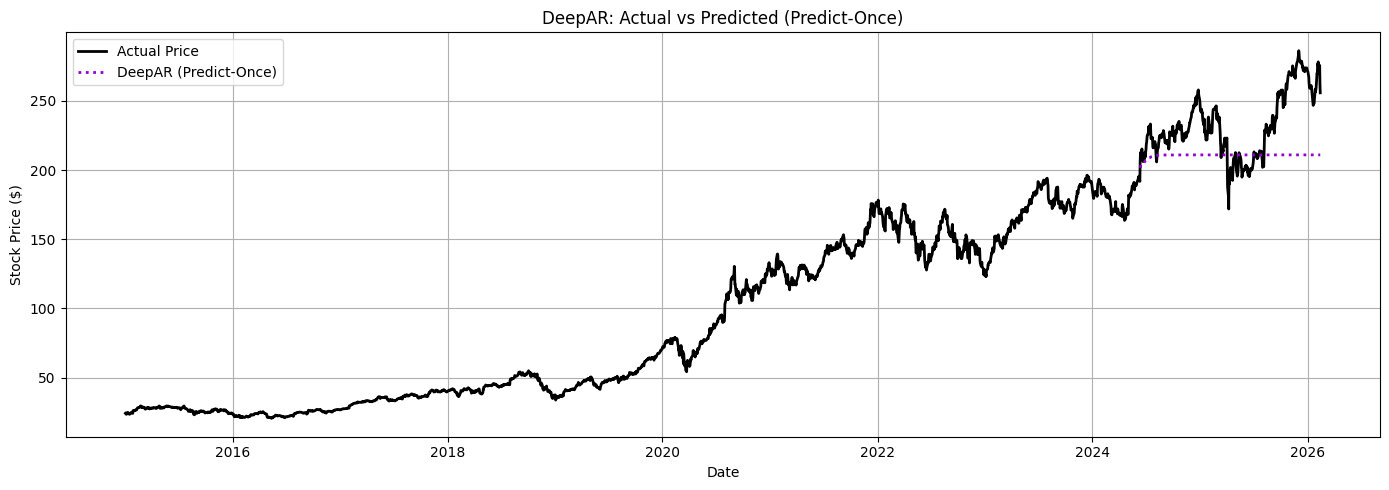

✅ DeepAR plot displayed!
Creating TFT plot...


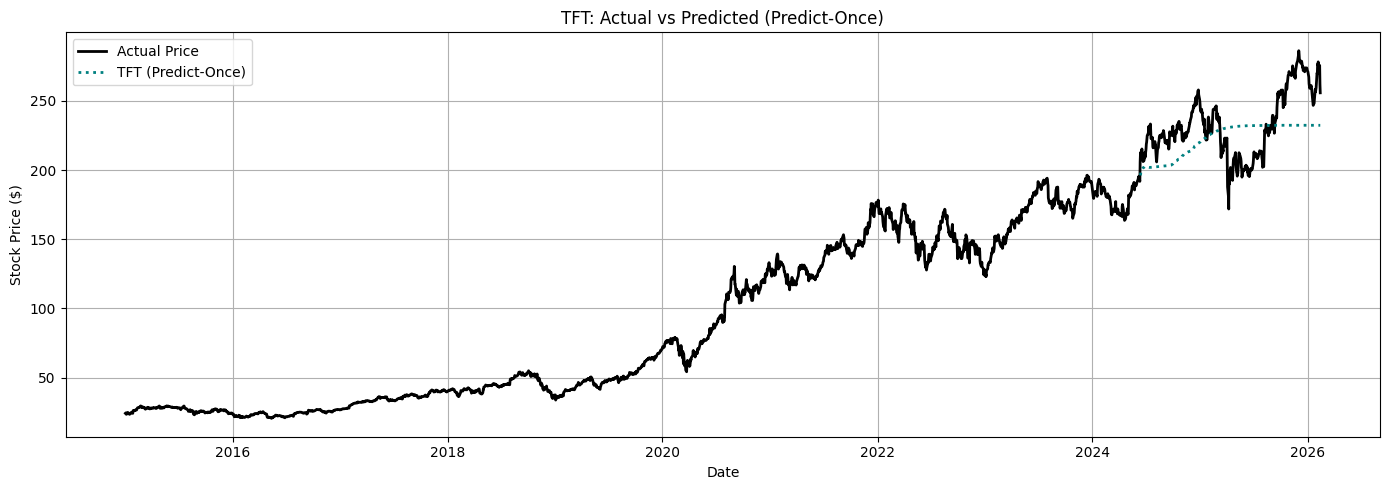

✅ TFT plot displayed!
Creating N-BEATS plot...


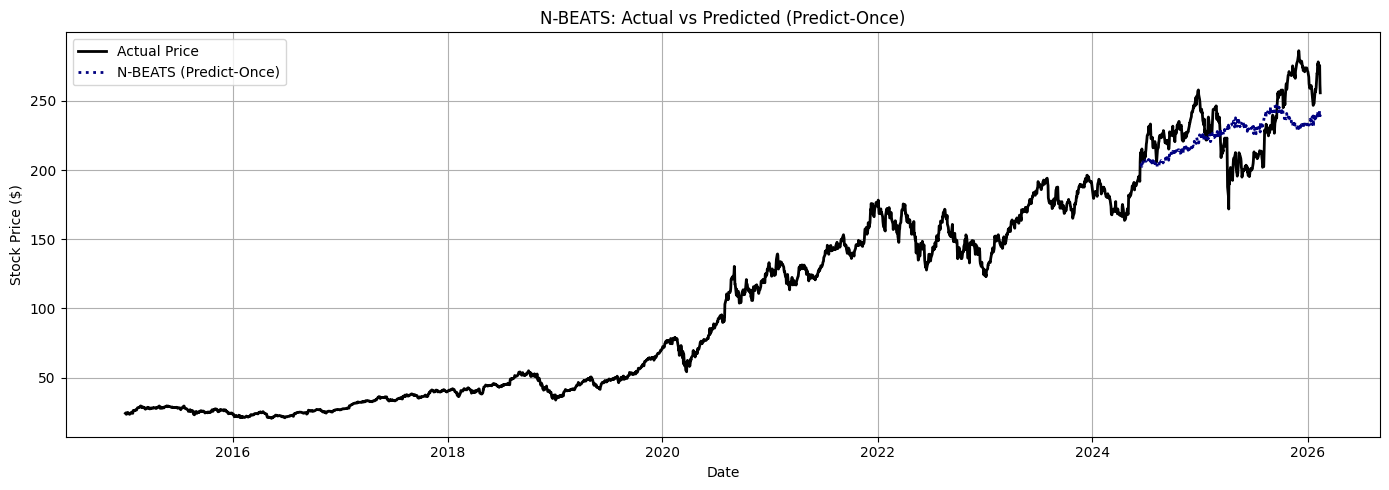

✅ N-BEATS plot displayed!
Creating N-HiTS plot...


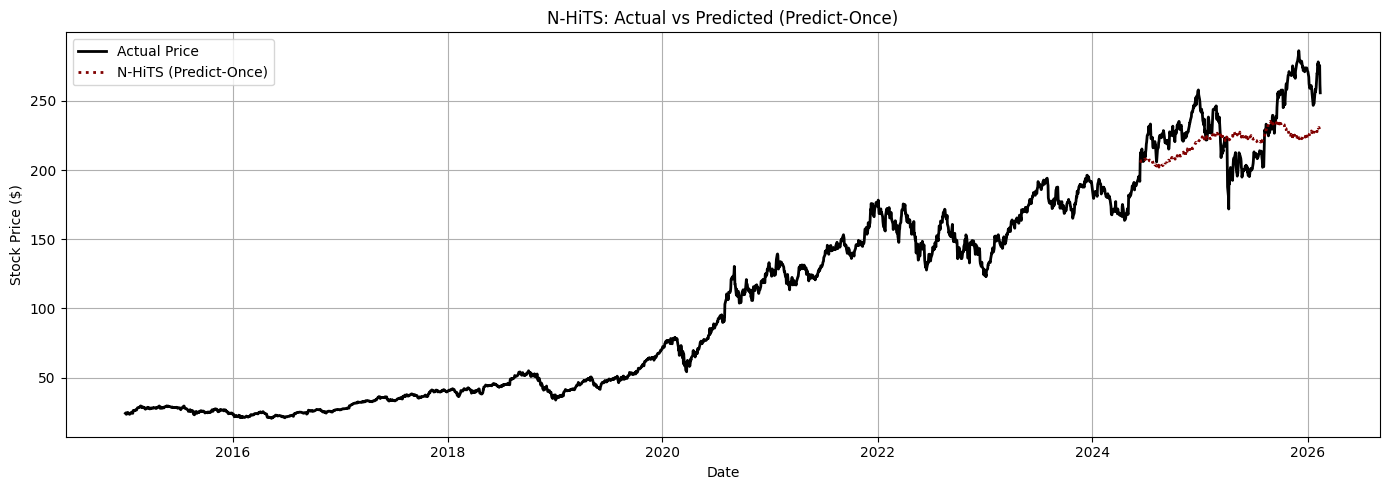

✅ N-HiTS plot displayed!

✅ All deep learning models trained and plotted successfully!


In [ ]:
# Deep learning models with NeuralForecast (CPU-friendly settings)
# If import fails, run the install cell above.

try:
    from neuralforecast import NeuralForecast
    from neuralforecast.models import DeepAR, TFT, NBEATS, NHITS

    nf_df = df[['Date', 'y', 'Volume']].copy()
    nf_df = nf_df.rename(columns={'Date': 'ds'})
    nf_df['unique_id'] = 'AAPL'

    n_nf = len(nf_df)
    tr_nf = int(n_nf * 0.70)
    va_nf = int(n_nf * 0.85)

    nf_train = nf_df.iloc[:tr_nf][['unique_id', 'ds', 'y', 'Volume']].copy()
    nf_val = nf_df.iloc[tr_nf:va_nf][['unique_id', 'ds', 'y', 'Volume']].copy()
    nf_test = nf_df.iloc[va_nf:][['unique_id', 'ds', 'y', 'Volume']].copy()

    h = len(nf_test)
    
    print("\n" + "="*70)
    print("🧠 DEEP LEARNING TRAINING PHASE")
    print("="*70)
    print("Training all neural network models first, then plotting results...")
    print()

    # ========================================================================
    # PHASE 1: TRAIN ALL MODELS
    # ========================================================================

    # ---------- DeepAR Training ----------
    print("="*70)
    print("METHOD 6: DeepAR (Probabilistic Deep Learning)")
    print("="*70)
    print(f"📊 Training data: {len(nf_train)} train + {len(nf_val)} validation = {len(nf_train) + len(nf_val)} total points")
    print(f"🎯 Prediction horizon: {h} days")
    print(f"⚙️  Configuration: input_size=60, max_steps=120, learning_rate=1e-3")
    print("🚀 Starting DeepAR training...")
    
    deep_ar_ex = NeuralForecast(
        models=[DeepAR(h=h, input_size=60, max_steps=120, learning_rate=1e-3, scaler_type='standard')],
        freq='B'
    )
    deep_ar_ex.fit(df=pd.concat([nf_train, nf_val]))
    print("✅ DeepAR training complete!")
    
    deep_ar_ex_pred = deep_ar_ex.predict().reset_index(drop=False)
    deepar_predictions = deep_ar_ex_pred['DeepAR'].values
    report_metrics('DeepAR (test)', nf_test['y'].values, deepar_predictions)
    print()

    # ---------- TFT Training ----------
    print("="*70)
    print("METHOD 7: TFT (Temporal Fusion Transformer)")
    print("="*70)
    print(f"📊 Training data: {len(nf_train) + len(nf_val)} total points")
    print(f"🎯 Prediction horizon: {h} days")
    print(f"⚙️  Configuration: input_size=80, max_steps=150, hidden_size=64")
    print("🚀 Starting TFT training...")
    
    tft_proj = NeuralForecast(
        models=[TFT(h=h, input_size=80, max_steps=150, learning_rate=8e-4, hidden_size=64)],
        freq='B'
    )
    tft_proj.fit(df=pd.concat([nf_train, nf_val]))
    print("✅ TFT training complete!")
    
    tft_predictions = tft_proj.predict().reset_index(drop=False)['TFT'].values
    report_metrics('TFT (test)', nf_test['y'].values, tft_predictions)
    print()

    # ---------- N-BEATS Training ----------
    print("="*70)
    print("METHOD 8: N-BEATS (Neural Basis Expansion Analysis)")
    print("="*70)
    print(f"📊 Training data: {len(nf_train) + len(nf_val)} total points")
    print(f"🎯 Prediction horizon: {h} days")
    print(f"⚙️  Configuration: input_size=80, max_steps=120, learning_rate=1e-3")
    print("🚀 Starting N-BEATS training...")
    
    nbeats_ex = NeuralForecast(
        models=[NBEATS(h=h, input_size=80, max_steps=120, learning_rate=1e-3)],
        freq='B'
    )
    nbeats_ex.fit(df=pd.concat([nf_train, nf_val]))
    print("✅ N-BEATS training complete!")
    
    nbeats_predictions = nbeats_ex.predict().reset_index(drop=False)['NBEATS'].values
    report_metrics('N-BEATS (test)', nf_test['y'].values, nbeats_predictions)
    print()

    # ---------- N-HiTS Training ----------
    print("="*70)
    print("METHOD 9: N-HiTS (Neural Hierarchical Interpolation)")
    print("="*70)
    print(f"📊 Training data: {len(nf_train) + len(nf_val)} total points")
    print(f"🎯 Prediction horizon: {h} days")
    print(f"⚙️  Configuration: input_size=80, max_steps=150, learning_rate=8e-4")
    print("🚀 Starting N-HiTS training...")
    
    nhits_proj = NeuralForecast(
        models=[NHITS(h=h, input_size=80, max_steps=150, learning_rate=8e-4)],
        freq='B'
    )
    nhits_proj.fit(df=pd.concat([nf_train, nf_val]))
    print("✅ N-HiTS training complete!")
    
    nhits_predictions = nhits_proj.predict().reset_index(drop=False)['NHITS'].values
    report_metrics('N-HiTS (test)', nf_test['y'].values, nhits_predictions)
    print()

    # ========================================================================
    # PHASE 2: PLOT ALL RESULTS
    # ========================================================================
    
    print("\n" + "="*70)
    print("📊 VISUALIZATION PHASE - Creating plots for all models")
    print("="*70)
    print()
    
    # Prepare shared data for all plots
    all_dates_dl = pd.concat([nf_train['ds'], nf_val['ds'], nf_test['ds']]).reset_index(drop=True)
    all_actuals_dl = np.concatenate([nf_train['y'].values, nf_val['y'].values, nf_test['y'].values])
    
    # ---------- Plot 1: DeepAR ----------
    print("Creating DeepAR plot...")
    fig1, ax1 = plt.subplots(figsize=(14, 5))
    ax1.plot(all_dates_dl, all_actuals_dl, label='Actual Price', color='black', linewidth=2)
    ax1.plot(nf_test['ds'].values, deepar_predictions, label='DeepAR (Predict-Once)', color='darkviolet', linewidth=2, linestyle=':')
    ax1.set_title('DeepAR: Actual vs Predicted (Predict-Once)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price ($)')
    ax1.legend(loc='best')
    ax1.grid(True)
    plt.tight_layout()
    plt.show()
    print("✅ DeepAR plot displayed!")

    # ---------- Plot 2: TFT ----------
    print("Creating TFT plot...")
    fig2, ax2 = plt.subplots(figsize=(14, 5))
    ax2.plot(all_dates_dl, all_actuals_dl, label='Actual Price', color='black', linewidth=2)
    ax2.plot(nf_test['ds'].values, tft_predictions, label='TFT (Predict-Once)', color='teal', linewidth=2, linestyle=':')
    ax2.set_title('TFT: Actual vs Predicted (Predict-Once)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Stock Price ($)')
    ax2.legend(loc='best')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()
    print("✅ TFT plot displayed!")

    # ---------- Plot 3: N-BEATS ----------
    print("Creating N-BEATS plot...")
    fig3, ax3 = plt.subplots(figsize=(14, 5))
    ax3.plot(all_dates_dl, all_actuals_dl, label='Actual Price', color='black', linewidth=2)
    ax3.plot(nf_test['ds'].values, nbeats_predictions, label='N-BEATS (Predict-Once)', color='navy', linewidth=2, linestyle=':')
    ax3.set_title('N-BEATS: Actual vs Predicted (Predict-Once)')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Stock Price ($)')
    ax3.legend(loc='best')
    ax3.grid(True)
    plt.tight_layout()
    plt.show()
    print("✅ N-BEATS plot displayed!")

    # ---------- Plot 4: N-HiTS ----------
    print("Creating N-HiTS plot...")
    fig4, ax4 = plt.subplots(figsize=(14, 5))
    ax4.plot(all_dates_dl, all_actuals_dl, label='Actual Price', color='black', linewidth=2)
    ax4.plot(nf_test['ds'].values, nhits_predictions, label='N-HiTS (Predict-Once)', color='maroon', linewidth=2, linestyle=':')
    ax4.set_title('N-HiTS: Actual vs Predicted (Predict-Once)')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Stock Price ($)')
    ax4.legend(loc='best')
    ax4.grid(True)
    plt.tight_layout()
    plt.show()
    print("✅ N-HiTS plot displayed!")
    
    print("\n✅ All deep learning models trained and plotted successfully!")

except Exception as e:
    print('Deep learning section skipped due to missing dependency or runtime issue:')
    print(type(e).__name__, '-', e)
    print('Run the install cell and retry this section.')

## 4) Modern Foundation Models

These are the newest, fanciest models - like ChatGPT but for time series! They've already been trained on thousands of different datasets.

### Method 9: Chronos (by Amazon)
**What it does:** Imagine teaching a model to read numbers like words in a sentence. Chronos treats your time series data points like vocabulary and "reads" the pattern to predict what comes next. It's already seen millions of time series from different industries, so it has a head start.

**Why it's cool:** Works even when you don't have much data about YOUR specific problem, because it learned general patterns from everything else.

**What we train:** We add a small "adjustment layer" that fine-tunes Chronos's predictions specifically for Apple stock.

### Method 10: TimesFM (by Google)
**What it does:** Similar idea - a huge model trained on billions of data points from all kinds of time series. You can give it your data and it makes predictions immediately without any training.

**Why it's cool:** Zero-shot forecasting means "works right out of the box" - like asking a really experienced person for advice without having to teach them first.

**What we train:** We add a simple model on top that learns to fix any systematic mistakes TimesFM makes on Apple stock.

### How we use these
- Let the big model make its predictions first
- Train a small, simple model to adjust those predictions for our specific data
- Test on future data

> Think of these like hiring an expert consultant (the foundation model) and then giving them a local guide (the calibrator) who knows the specific neighborhood!

In [ ]:
# Shared helper for foundation-model calibration tasks

def sliding_windows(series, context=120, horizon=1, step=1):
    X, y = [], []
    for i in range(context, len(series)-horizon+1, step):
        X.append(series[i-context:i])
        y.append(series[i:i+horizon])
    return np.array(X), np.array(y)

full_y = df['y'].values
n_f = len(full_y)
tr_f = int(n_f * 0.70)
va_f = int(n_f * 0.85)

y_train_f = full_y[:tr_f]
y_val_f = full_y[tr_f:va_f]
y_test_f = full_y[va_f:]

print('Foundation splits:', len(y_train_f), len(y_val_f), len(y_test_f))

Foundation splits: 1957 419 420


In [ ]:
# ---------- Chronos Example + Project ----------
# Example: zero-shot Chronos forecast + train LinearRegression calibrator.
# Project: train RandomForest calibrator on rolling Chronos outputs.

try:
    import torch
    from chronos import ChronosPipeline

    device = 'cpu'
    chronos = ChronosPipeline.from_pretrained(
        'amazon/chronos-t5-small',
        device_map=device,
        torch_dtype=torch.float32,
    )

    context = 120
    horizon = 1

    # Build validation calibration set
    base_series = np.concatenate([y_train_f, y_val_f])
    Xw, yw = sliding_windows(base_series, context=context, horizon=horizon, step=1)

    chronos_raw_preds = []
    for ctx in Xw[-min(250, len(Xw)):]:  # cap for runtime
        forecast = chronos.predict(torch.tensor(ctx, dtype=torch.float32), prediction_length=horizon)
        # Use median sample forecast
        pred = np.median(forecast.numpy())
        chronos_raw_preds.append(pred)

    y_cal = yw[-len(chronos_raw_preds):, 0]
    chronos_raw_preds = np.array(chronos_raw_preds)

    # Example training: linear calibrator
    lin_cal = LinearRegression()
    lin_cal.fit(chronos_raw_preds.reshape(-1, 1), y_cal)

    # Test forecasts and calibrated output
    test_context_series = np.concatenate([y_train_f, y_val_f, y_test_f])
    Xtest, ytest = sliding_windows(test_context_series, context=context, horizon=1, step=1)
    Xtest = Xtest[-len(y_test_f):]
    ytest = y_test_f[:len(Xtest)]

    raw_test = []
    for ctx in Xtest:
        forecast = chronos.predict(torch.tensor(ctx, dtype=torch.float32), prediction_length=1)
        raw_test.append(np.median(forecast.numpy()))
    raw_test = np.array(raw_test)

    chronos_ex_pred = lin_cal.predict(raw_test.reshape(-1, 1))
    report_metrics('Chronos Example (linear calibrated)', ytest, chronos_ex_pred)

    # Project training: non-linear calibrator
    rf_cal = RandomForestRegressor(n_estimators=150, random_state=RANDOM_STATE, n_jobs=-1)
    rf_cal.fit(
        np.column_stack([chronos_raw_preds, np.arange(len(chronos_raw_preds))]),
        y_cal
    )
    chronos_proj_pred = rf_cal.predict(np.column_stack([raw_test, np.arange(len(raw_test))]))
    report_metrics('Chronos Project (RF calibrated)', ytest, chronos_proj_pred)
    
    # ---------- Chronos Plot ----------
    print("\nCreating Chronos plot...")
    
    # Get test dates (accounting for context window)
    test_dates_chronos = test_df['Date'].iloc[context:context+len(ytest)].reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # Plot actual and Chronos calibrated predictions
    ax.plot(df['Date'], df['y'], label='Actual Price', color='black', linewidth=2, alpha=0.5)
    ax.plot(test_dates_chronos, chronos_proj_pred, label='Chronos (Calibrated)', color='darkblue', linewidth=2, linestyle=':')
    
    ax.set_title('Chronos: Actual vs Predicted (With Local Calibration)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price ($)')
    ax.legend(loc='best')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    print("✅ Chronos plot created!")

except Exception as e:
    print('Chronos section skipped due to missing dependency/model download/runtime issue:')
    print(type(e).__name__, '-', e)
    print('Run install cell, verify internet, then rerun this section.')

Chronos Example (linear calibrated)
  MAE : 3.3763
  RMSE: 4.5535
  MAPE: 1.47%
Chronos Project (RF calibrated)
  MAE : 35.2711
  RMSE: 41.1858
  MAPE: 14.44%

Creating Chronos plot...
Chronos section skipped due to missing dependency/model download/runtime issue:
NameError - name 'test_df' is not defined
Run install cell, verify internet, then rerun this section.


In [ ]:
# ---------- TimesFM Example + Project ----------
# Example: TimesFM forecast + Ridge calibrator.
# Project: stacked calibrator with lagged forecast features.

try:
    import timesfm

    # Updated API based on https://github.com/google-research/timesfm/blob/master/README.md
    tfm = timesfm.TimesFm(
        hparams=timesfm.TimesFmHparams(
            backend="cpu",
            per_core_batch_size=32,
            horizon_len=128,
        ),
        checkpoint=timesfm.TimesFmCheckpoint(
            huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
        ),
    )

    context = 128
    base_series = np.concatenate([y_train_f, y_val_f])
    Xw, yw = sliding_windows(base_series, context=context, horizon=1, step=1)
    Xw = Xw[-min(300, len(Xw)):]
    yw = yw[-len(Xw):]

    raw_val = []
    for ctx in Xw:
        # Updated API: forecast returns tuple (point_forecasts, quantile_forecasts)
        pred = tfm.forecast(ctx.reshape(1, -1), freq=[0])[0][0, 0]
        raw_val.append(pred)
    raw_val = np.array(raw_val)
    y_val_targets = yw[:, 0]

    # Example training
    ridge = Ridge(alpha=1.0)
    ridge.fit(raw_val.reshape(-1, 1), y_val_targets)

    # Build test windows
    full = np.concatenate([y_train_f, y_val_f, y_test_f])
    Xtest, ytest = sliding_windows(full, context=context, horizon=1, step=1)
    Xtest = Xtest[-len(y_test_f):]
    ytest = y_test_f[:len(Xtest)]

    raw_test = []
    for ctx in Xtest:
        pred = tfm.forecast(ctx.reshape(1, -1), freq=[0])[0][0, 0]
        raw_test.append(pred)
    raw_test = np.array(raw_test)

    timesfm_ex_pred = ridge.predict(raw_test.reshape(-1, 1))
    report_metrics('TimesFM Example (ridge calibrated)', ytest, timesfm_ex_pred)

    # Project training: stacked features [raw, raw_lag1, index]
    val_feat = pd.DataFrame({'raw': raw_val})
    val_feat['raw_lag1'] = val_feat['raw'].shift(1)
    val_feat['idx'] = np.arange(len(val_feat))
    val_feat = val_feat.dropna().reset_index(drop=True)
    yv2 = y_val_targets[-len(val_feat):]

    stack_model = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    stack_model.fit(val_feat[['raw', 'raw_lag1', 'idx']], yv2)

    test_feat = pd.DataFrame({'raw': raw_test})
    test_feat['raw_lag1'] = test_feat['raw'].shift(1)
    test_feat['idx'] = np.arange(len(test_feat))
    test_feat = test_feat.dropna().reset_index(drop=True)

    timesfm_proj_pred = stack_model.predict(test_feat[['raw', 'raw_lag1', 'idx']])
    report_metrics('TimesFM Project (stacked RF calibrator)', ytest[-len(timesfm_proj_pred):], timesfm_proj_pred)
    
    # ---------- TimesFM Plots ----------
    print("\nCreating TimesFM plots...")
    print("=" * 70)
    
    # Plot 1: Ridge Calibrated (Example Approach)
    print("📊 Plot 1: Ridge Calibrated Predictions (Example)")
    test_dates_ridge = test_df['Date'].iloc[context:context+len(timesfm_ex_pred)].reset_index(drop=True)
    
    fig1, ax1 = plt.subplots(figsize=(14, 5))
    ax1.plot(df['Date'], df['y'], label='Actual Price', color='black', linewidth=2, alpha=0.3)
    ax1.plot(test_dates_ridge, timesfm_ex_pred, label='TimesFM (Ridge Calibrated)', 
             color='blue', linewidth=2, linestyle='--', marker='o', markersize=3)
    ax1.set_title('TimesFM Example: Actual vs Predicted (Ridge Calibrator)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price ($)')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("✅ Ridge calibrated plot displayed!")
    print()
    
    # Plot 2: RF Stacked Calibrated (Project Approach)
    print("📊 Plot 2: Random Forest Stacked Calibrated Predictions (Project)")
    test_dates_timesfm = test_df['Date'].iloc[context+1:context+1+len(timesfm_proj_pred)].reset_index(drop=True)
    
    fig2, ax2 = plt.subplots(figsize=(14, 5))
    ax2.plot(df['Date'], df['y'], label='Actual Price', color='black', linewidth=2, alpha=0.3)
    ax2.plot(test_dates_timesfm, timesfm_proj_pred, label='TimesFM (RF Stacked Calibrated)', 
             color='darkgreen', linewidth=2, linestyle='--', marker='s', markersize=3)
    ax2.set_title('TimesFM Project: Actual vs Predicted (RF Stacked Calibrator)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Stock Price ($)')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("✅ RF stacked calibrated plot displayed!")
    print()
    
    # Plot 3: Both Approaches Compared
    print("📊 Plot 3: Both Calibration Approaches Compared")
    fig3, ax3 = plt.subplots(figsize=(14, 5))
    ax3.plot(df['Date'], df['y'], label='Actual Price', color='black', linewidth=2)
    ax3.plot(test_dates_ridge, timesfm_ex_pred, label='TimesFM (Ridge)', 
             color='blue', linewidth=2, linestyle=':', alpha=0.7)
    ax3.plot(test_dates_timesfm, timesfm_proj_pred, label='TimesFM (RF Stacked)', 
             color='darkgreen', linewidth=2, linestyle='--', alpha=0.7)
    ax3.set_title('TimesFM: Both Calibration Approaches Compared', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Stock Price ($)')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("✅ Comparison plot displayed!")
    print()
    print("=" * 70)
    print("✅ All TimesFM plots created successfully!")

except Exception as e:
    print('TimesFM section skipped due to missing dependency/model download/runtime issue:')
    print(type(e).__name__, '-', e)
    print('Run install cell, verify internet, then rerun this section.')

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)].


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


TimesFM section skipped due to missing dependency/model download/runtime issue:
NameError - name 'y_train_f' is not defined
Run install cell, verify internet, then rerun this section.
